In [52]:
from datetime import date
import datetime 
import shutil
import pandas as pd
import yfinance as yf
pd.set_option('display.max_rows',None)
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
import openpyxl


def move_download(TICKER):
    source = f'C:/Users/joaom/Downloads/{TICKER}.csv'
    destination = 'C:/Users/joaom/OneDrive/Documentos/GitHub/Snp1000/Performance Tables'
    dest = shutil.move(source, destination) 

companies = pd.read_csv('03_Tables/SnP1000_TICKR.csv')
companies_list = companies['Companie'].to_list()
df = pd.DataFrame()

today = date.today()
current_day = int(today.strftime('%d'))
current_month = int(today.strftime('%m'))
current_year = int('20'+today.strftime('%y'))

start = datetime.date(2020,10,19)
end = datetime.date(current_year,current_month,current_day)

#Module 1 - Get data
companies_list=['TSLA']
for i in companies_list[:1]:
    print(str(companies_list.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)
    try:
        stock = []
        stock = yf.download(i, start=start, end=end, progress=False)
        if len(stock) == 0:
            None
        else:
            stock['Name'] = i
            df = df.append(stock, sort=False)
    except Exception:
        None


0 : TSLA,

In [53]:
#Module 2 - Calculate RSI (relative Strength Index)
#df = df.iloc[-60:] # Get just about the last two months of data

df.reset_index(inplace=True)
df['Change'] = (df['Close'].shift(-1)-df['Close']).shift(1)
df['ChangeAverage'] = df['Change'].rolling(window=2).mean()
df['ChangeAverage+'] = df.apply(lambda x: x['ChangeAverage'] if x['ChangeAverage'] > 0 else 0,axis=1).rolling(window=14).mean()
df['ChangeAverage-'] = df.apply(lambda x: x['ChangeAverage'] if x['ChangeAverage'] < 0 else 0,axis=1).rolling(window=14).mean()*-1
df['RSI'] = 100-(100/(1+(df['ChangeAverage+']/df['ChangeAverage-'])))
df = df.drop(columns = ['ChangeAverage','ChangeAverage','ChangeAverage'])


In [54]:
#Module 3 - Calculate OBV (On Balance Volume) 
VolumeList = df['Volume'].tolist()
OBV = [VolumeList[0]]
i=1
for i in range(1,len(VolumeList)):
    #i=i+1
    if VolumeList[i] > VolumeList[i-1]:
        OBV.append(OBV[i-1]+VolumeList[i])
        continue
    if VolumeList[i]==VolumeList[i-1]:
        OBV.append(OBV[i-1]+0)
        continue
    if VolumeList[i]<VolumeList[i-1]:
        OBV.append(OBV[i-1]-VolumeList[i])
        continue  
df['OBV'] = OBV

#Module 4 - Calculate Linear Regressions on Close and OBV plus errors

OBV_regression = [0 for x in range(delay)]
OBV_regression_err = [0 for x in range(delay)]
Close_regression = [0 for x in range(delay)]
Close_regression_err = [0 for x in range(delay)]

Date = df['Date'].tolist()

# Calculating OBV trends
delay=15 # How many trading days to calculate moving slopes
x = np.array([x for x in range(delay)])
for i in range(delay,len(OBV)):
    y = df['OBV'].iloc[i-delay:i].values
    slope, intercept, r_value, p_value, err = stats.linregress(x,y)
    OBV_regression.append(slope)
    OBV_regression_err.append(err)

# Calculating Close trends
delay=15 # How many trading days to calculate moving slopes
x = np.array([x for x in range(delay)])
for i in range(delay,len(OBV)):
    y2 = df['Close'].iloc[i-delay:i].values
    slope2, intercept2, r_value2, p_value2, err2 = stats.linregress(x,y2)
    Close_regression.append(slope2)
    Close_regression_err.append(err2)

df['OBV_Regression'] = OBV_regression
df['OBV_Regression'] = 100*(df['OBV_Regression'])/max(df['OBV_Regression'])
df['OBV_Regression_err'] = OBV_regression_err
df['Close_Regression'] = Close_regression
df['Close_Regression_err'] = Close_regression_err


df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']


#df = df.drop(['ChangeAverage+','ChangeAverage-','OBV_Regression_err','Close_Regression_err'], axis  = 1)


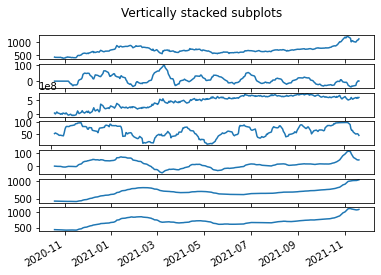

In [55]:
from matplotlib.dates import DateFormatter

fig, axs = plt.subplots(7)
fig.suptitle('Vertically stacked subplots')

axs[0].plot(df['Date'], df['Close'])
axs[1].plot(df['Date'], df['OBV_Regression'])
axs[2].plot(df['Date'], df['OBV'])
axs[3].plot(df['Date'], df['RSI'])
axs[4].plot(df['Date'], df['MACD'])
axs[5].plot(df['Date'], df['EMA26'])
axs[6].plot(df['Date'], df['EMA12'])


fig.autofmt_xdate()
plt.show()

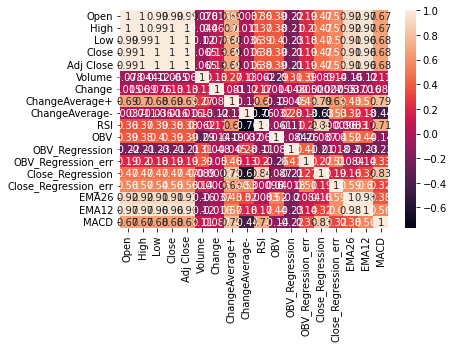

In [56]:
# data = tesla[['Date','RSI']]
# dataOBV = tesla[['','OBV']]

# correlation = data.corr(method='pearson')
# correlationOBV = dataOBV.corr(method='pearson')

# print(correlation)
# print(correlationOBV)

import seaborn as sn
import matplotlib.pyplot as plt


corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [57]:
def Score():
    if df['RSI'].iloc[-1] < 30 and df['RSI'].iloc[-1] <70:
        print('RSI Check failed')
    else:
        print('RSI Positive')
    if df['OBV_Regression'].iloc[-1] < 50:
        print('OBV Positive')
    else:
        print('OBV Check failed ')
Score()

RSI Positive
OBV Positive


In [59]:
#Export to Excel (clean excel sheet initially to always paste correctly)
filename_csv = 'Outputs/tesla.csv'
df.to_csv(filename_csv)
print('DataFrame is written successfully to CSV Sheet.')

DataFrame is written successfully to CSV Sheet.
